In [2]:
# Import the necessary libraries
import qiskit
from qiskit import *
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pylatexenc
from scipy.optimize import minimize
from qiskit.extensions import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
import math
import cmath
import random
import timeit

In [3]:
# Note that for the Poisson Problem, the right side is taken as a vector of constants after discretization where
# f = [1,1,1,1,1,1,1,1]^T with two additional boundary points (u(0) and u(1))
def create_b(circuit,qubits):
    for i in qubits:
        circuit.h(i)

def create_b_dagger(circuit, qubits):
    create_b(circuit,qubits)

In [20]:
ansatz_param = None

#def create_ansatz(circuit, qubit_list, layers, final_layer=False):
#    param_idx = 0
#    for k in range(layers):
#        for i in range(len(qubit_list)):
#            circuit.ry(ansatz_param[param_idx+i], qubit_list[i])
#        param_idx += 4
#        if k != layers - 1:
#            circuit.cz(qubit_list[0], qubit_list[1])
#            circuit.cz(qubit_list[1], qubit_list[2])
#            circuit.cz(qubit_list[2], qubit_list[3])

# def create_ansatz(circuit, qubit_list, layers, final_layer=False):
#     param_idx = 0
#     for i in range(len(qubit_list)):
#         circuit.ry(ansatz_param[param_idx], qubit_list[i])
#         param_idx += 1
#     for k in range(layers):
#         circuit.cz(qubit_list[0], qubit_list[1])
#         circuit.cz(qubit_list[2], qubit_list[3])
#         for i in range(len(qubit_list)):
#             circuit.ry(ansatz_param[param_idx], qubit_list[i])
#             param_idx += 1
#         circuit.cz(qubit_list[1], qubit_list[2])
#         circuit.ry(ansatz_param[param_idx], qubit_list[1])
#         circuit.ry(ansatz_param[param_idx+1], qubit_list[2])
#         param_idx += 2

def create_ansatz(circuit, qubit_list, layers):
    param_index = 0
    for i in range(len(qubit_list)):
            circuit.ry(ansatz_param[param_index], qubit_list[i])
            param_index += 1
    for k in range(layers):
        circuit.cz(qubit_list[0], qubit_list[1])
        circuit.cz(qubit_list[2], qubit_list[3])
        for i in range(len(qubit_list)):
            circuit.ry(ansatz_param[param_index], qubit_list[i])
            param_index += 1
        circuit.cz(qubit_list[1], qubit_list[2])
        circuit.ry(ansatz_param[param_index], qubit_list[1])
        circuit.ry(ansatz_param[param_index+1], qubit_list[2])
        param_index += 2

In [5]:
def get_submatrix(elm):
    matrix_list = []
    for k in range(len(elm)):
        if elm[k] == 'I':
            mat = I
        elif elm[k] == 'X':
            mat = X
        else:
            mat = Y
        matrix_list.append(mat)
    sub_matrix = np.kron(np.kron(np.kron(matrix_list[0], matrix_list[1]), matrix_list[2]), matrix_list[3])
    return sub_matrix
    

c = []

I = np.eye(2)
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

matrix_array = ['IIII', 'IIIX','IIXX','IXXX','XXXX','YYXX','YXYX','IYYX',
                'XYYX','YXXY','IYXY','XYXY','IIYY','IXYY','XXYY','YYYY']

A = np.zeros((16,16))
for i in range(16):
    for j in range(16):
        if i == j:
            A[i,j] = 2
        elif i == j+1 or i == j-1:
            A[i,j] = -1
        else:
            pass


# To find the co-efficient list
for element in matrix_array:
    Al = get_submatrix(element)
    coef = (1/16) * np.trace(Al @ A)
    c.append(coef)

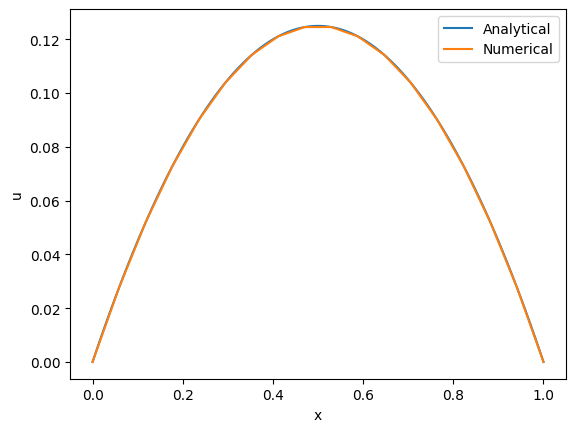

In [6]:
b = np.ones(16)
b = b / (17**2)
u = np.linalg.solve(A, b)

def analytical_poisson(x):
    return 0.5 * (x - x**2)

x_analytical = np.linspace(0,1,100)
x_num = np.linspace(0,1,18)
sol_analytical = analytical_poisson(x_analytical)
u_num = np.zeros(18)
for i in range(16):
    u_num[i+1] = u[i]

plt.plot(x_analytical, sol_analytical, label='Analytical')
plt.plot(x_num, u_num, label='Numerical')
plt.xlabel('x')
plt.ylabel('u')
plt.legend()
plt.show()

In [7]:
def generate_matrix(circuit, elm):
    for k in range(len(elm)):
        if elm[k] == 'I':
            pass
        elif elm[k] == 'X':
            circuit.cx(0, k+1)
        else:
            circuit.cy(0, k+1)

def create_A(circuit,idx):
    if idx == 0:
        None
    else:
        matrix_entry = matrix_array[idx]
        generate_matrix(circuit, matrix_entry)

def create_A_dagger(circuit, idx):
    create_A(circuit,idx)

In [21]:
# Specify parameters
shots = 100000
backend = Aer.get_backend('qasm_simulator')
noise_model = None
n_qubit = np.log2(len(b))
n_qubit = int(n_qubit)

# Create the function to evaluate the denominator of the Hadamard Test
def denom_Hadamard(l,lp,part='Re'):
    quantum_circuit = QuantumCircuit(n_qubit+1,1)
    quantum_circuit.h(0)
    
    if part == 'Im':
        quantum_circuit.sdg(0)
    
    create_ansatz(quantum_circuit, [i+1 for i in range(n_qubit)], layer)
    create_A(quantum_circuit,l)
    create_A_dagger(quantum_circuit,lp)

    quantum_circuit.h(0)
    quantum_circuit.measure(0,0)

    job = execute(quantum_circuit, backend=backend, shots=shots, noise_model=noise_model)
    result = job.result().get_counts()

    try:
        P0 = result["0"]
        P1 = shots - P0
    except:
        P1 = shots
        P0 = 0
    
    beta_denom = (P0 - P1)/shots
    return beta_denom

# Create the function to evaluate the numerator of the Hadamard Test
def numer_Hadamard(l,lp,j,part="Re"):
    quantum_circuit = QuantumCircuit(n_qubit+1,1)
    quantum_circuit.h(0)

    if part == "Im":
        quantum_circuit.sdg(0)
    
    create_ansatz(quantum_circuit, [i+1 for i in range(n_qubit)], layer)
    create_A(quantum_circuit, l)
    create_b_dagger(quantum_circuit, [i+1 for i in range(n_qubit)])
    quantum_circuit.cz(0,j)
    create_b(quantum_circuit, [i+1 for i in range(n_qubit)])
    create_A_dagger(quantum_circuit, lp)

    quantum_circuit.h(0)
    quantum_circuit.measure(0,0)

    job = execute(quantum_circuit,backend=backend, shots=shots, noise_model=noise_model)
    result = job.result().get_counts()

    try:
        P0 = result["0"]
        P1 = shots - P0
    except:
        P1 = shots
        P0 = 0
    
    delta_num = (P0 - P1)/shots
    return delta_num

# Create the function for the classical evaluation of the cost function
def cost_function(ansatz_param_updated):
    global ansatz_param, iteration

    ansatz_param = ansatz_param_updated
    num_sum = 0
    denom_sum = 0
    
    #start = time.time()

    for l in range(len(c)):
        for lp in range(len(c)):
            denom_sum += (c[l] * np.conj(c[lp]) * denom_Hadamard(l,lp,"Re"))
            for j in range(1,n_qubit+1):
                num_sum += (c[l] * np.conj(c[lp]) * numer_Hadamard(l,lp,j,"Re"))
    
    x = 0.5 - 0.5*num_sum/(n_qubit * denom_sum)
    #x = 1 - num_sum*num_sum/denom_sum
    x = abs(x)
    
    #end = time.time()
    
    #print(f'Iteration: {iteration}\tCost Function: {x}\tExecution Time: {end - start}')
    #time_list.append(end - start)
    print(f'Iteration: {iteration}\tCost Function: {x}')
    cost_list.append(x)
    iteration += 1
    return x

In [23]:
layer = 8
cost_list = []
parameter_number = 6 * layer + n_qubit
theta0 = np.random.normal(0, np.pi/2, parameter_number)
#theta0 = [random.random() * 2 * np.pi for i in range(layer * 6 + n_qubit)]
iteration = 1
minimize(cost_function, x0=theta0, args=(), method="COBYLA", options={'maxiter':1000, 'rhobeg':np.pi, 'tol':1e-3})

Iteration: 1	Cost Function: 0.5053956573456971
Iteration: 2	Cost Function: 0.46894889960907893
Iteration: 3	Cost Function: 0.5004189724747649
Iteration: 4	Cost Function: 0.49287865827949345
Iteration: 5	Cost Function: 0.5771803739774425
Iteration: 6	Cost Function: 0.4600789765377911
Iteration: 7	Cost Function: 0.5184028691968076
Iteration: 8	Cost Function: 0.48644832972696994
Iteration: 9	Cost Function: 0.5838450811504844
Iteration: 10	Cost Function: 0.4609846487153825
Iteration: 11	Cost Function: 0.6002016578424971
Iteration: 12	Cost Function: 0.6704570047404119
Iteration: 13	Cost Function: 0.507095903708927
Iteration: 14	Cost Function: 0.45646747039862423
Iteration: 15	Cost Function: 0.40693530414170315
Iteration: 16	Cost Function: 0.4448835057915558
Iteration: 17	Cost Function: 0.43113509951675955
Iteration: 18	Cost Function: 0.45651313669138843
Iteration: 19	Cost Function: 0.5905618452920784
Iteration: 20	Cost Function: 0.3135171963414677
Iteration: 21	Cost Function: 0.436624240197

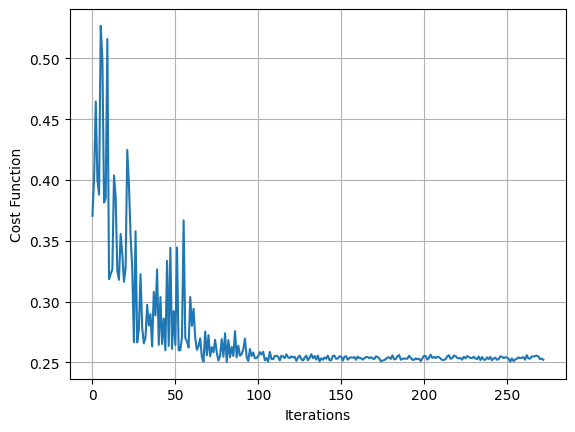

In [17]:
plt.plot(cost_list)
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.grid()
plt.show()

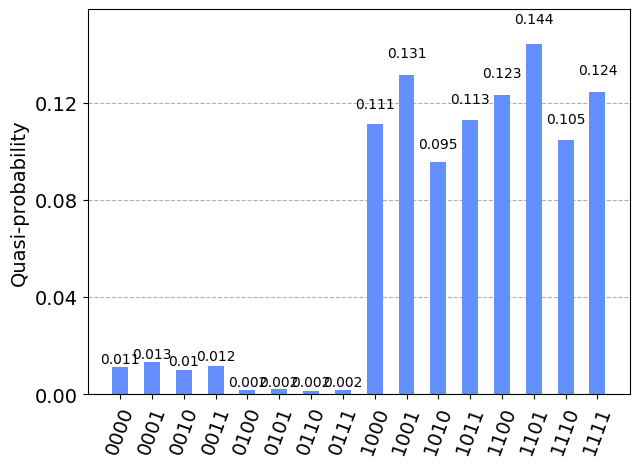

In [18]:
qc_final = QuantumCircuit(n_qubit)
create_ansatz(qc_final, [0,1,2,3], layers=layer)
qc_final.measure_all()
job = execute(qc_final, backend=backend, shots=100*shots, noise_model=noise_model)
result = job.result().get_counts()
for key in result:
    result[key] *= (0.01/shots)
plot_histogram(result)

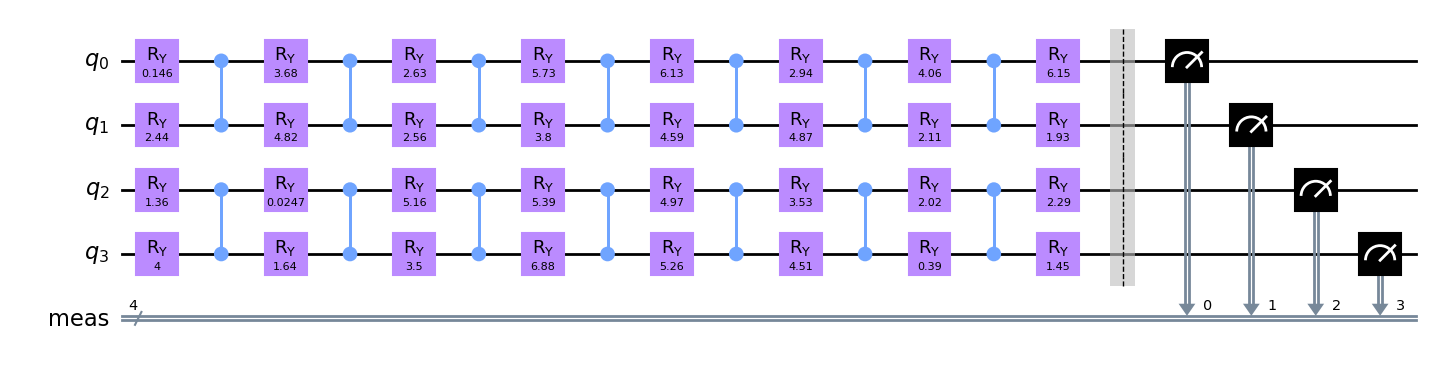

In [19]:
qc_final.draw('mpl')